In [1]:
import fipy as fipy
from fipy import *
import pylab
import matplotlib.pyplot as plt
import numpy as np

$$\frac{\partial u^{(i)}}{\partial t}=\bigtriangledown^2 u^{(i)} - \beta \bigtriangledown.\left[u^{(i)}\vec{x}_i\
\sum_{i \neq j}^{n}p^{(j)}\right], \hspace{35pt} i = 1... n, \hspace{35pt} (1)$$
$$\frac{\partial p^{(i)}}{\partial t}=u^{(i)}\left[1+m\sum_{i \neq j}^{n}p^{(j)}\right]-p^{(i)}, \hspace{35pt} i = 1... n, \hspace{35pt} (2)$$


Where

$u^{(i)}$: Density function for Home Range of individual i

$p$: function for marks of individual u


$\beta$: Advection-Difussion ratio

$\vec{x}_i$: Unit vector pointed at Home range center of individual i

$m$: sensitivity of individual to foreing marks

(Moorcroft & Lewis 2004)

1) Define a mesh 2D

In [4]:
nx = 100
ny = 100

dx = 1.
dy = dx

mesh = Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)
x = mesh.cellCenters[0]
y = mesh.cellCenters[1]

2) Define a multiple viewer

In [9]:
class ThreeViewer(Matplotlib2DGridViewer):
   def __init__(self, u1, u2, u3, title = None, limits ={}, **kwlimits):
       self.u1 = u1
       self.contour1 = None
       self.u2 = u2
       self.contour2 = None
       self.u3 = u3
       self.contour3 = None
       self.u3 = u3
       self.contour3 = None
       self.number = 10
       self.levels = None

       Matplotlib2DGridViewer.__init__(self, vars=(u1, u2, u3),title=title,cmap=None,limits ={}, **kwlimits)
        
   def _plot(self):
       Matplotlib2DGridViewer._plot(self)

       if hasattr(self, "_contourSet"):
           for countourSet in self._contourSet:
               for collection in ccontourSet.collections:
                   try:
                       ix = self.axes.collections.index(collection)
                   except ValueError, e:
                       ix = None

                   if ix is not None:
                       del self.axes.collections[ix]
       self._contourSet = []

       for var in (self.u1, self.u2, self.u3):
           mesh = var.mesh
           x, y = mesh.cellCenters
           z = var.value

           xmin, ymin = mesh.extents['min']
           xmax, ymax = mesh.extents['max']

           from matplotlib.mlab import griddata

           xi = fipy.numerix.linspace(xmin, xmax, 1000)
           yi = fipy.numerix.linspace(ymin, ymax, 1000)
           # grid the data.
           zi = griddata(x, y, z, xi, yi, interp='linear')


           zmin, zmax = self._autoscale(vars=[var],
                                        datamin=self._getLimit(('datamin', 'zmin')),
                                        datamax=self._getLimit(('datamax', 'zmax')))

           self.norm.vmin = zmin
           self.norm.vmax = zmax

           if self.levels is not None:
               levels = self.levels
           else:
               levels = fipy.numerix.arange(self.number + 1) * (zmax - zmin) / self.number + zmin


           self._contourSet.append(self.axes.contour(xi, yi, zi, levels=levels, cmap=None))

       self.axes.set_xlim(xmin=self._getLimit('xmin'),
                          xmax=self._getLimit('xmax'))

       self.axes.set_ylim(ymin=self._getLimit('ymin'),
                          ymax=self._getLimit('ymax'))

       if self.colorbar is not None:
               self.colorbar.plot()

3) Set up and plot the initial conditions

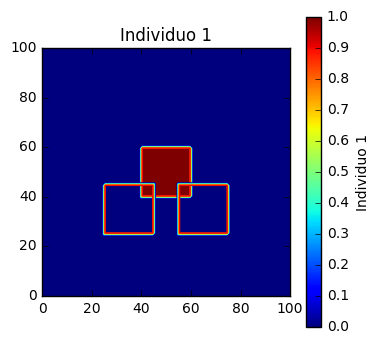

In [10]:
# Setting variable of results and adding inicial conditions

m = 1.

u1 = CellVariable(name="Individuo 1", mesh=mesh, value=0.)
u1.setValue(1., where=(40. < x) & (60. > x) & (40. < y) & (60. > y))

u2 = CellVariable(name="Individuo 2", mesh=mesh, value=0.)
u2.setValue(1., where=(25. < x) & (45. > x) & (25. < y) & (45. > y))

u3 = CellVariable(name="Individuo 3", mesh=mesh, value=0.)
u3.setValue(1., where=(55. < x) & (75. > x) & (25. < y) & (45. > y))

p1 = CellVariable(name= "Marcas Individuo 1", mesh=mesh, value=0.)
p1.setValue(1., where=(40. < x) & (60. > x) & (40. < y) & (60. > y))

p2 = CellVariable(name= "Marcas Individuo 2", mesh=mesh, value=0.)
p2.setValue(1., where=(25. < x) & (45. > x) & (25. < y) & (45. > y))

p3 = CellVariable(name= "Marcas Individuo 3", mesh=mesh, value=0.)
p3.setValue(1., where=(55. < x) & (75. > x) & (25. < y) & (45. > y))

dxx = (y**2 - y*x)/(numerix.sqrt(x**2 + y**2)*(x**2 + y**2))
dyy = (x**2 - x*y)/(numerix.sqrt(x**2 + y**2)*(x**2 + y**2))

# Plotting inicial conditions
if __name__ == '__main__':
    viewer = ThreeViewer(u1, u2, u3, datamin=0., datamax=1.0)
    viewer.plot()

### Question 1. Do you have any recommendation to improve the above code for plotting? I do not get plotting every individual with the same format (contour plot).

4) Define Difussion and Advection coefficients

In [11]:
D = 1.

C1 = CellVariable(mesh=mesh, rank=1)
C1[:]=1.
C1.setValue(-1., where = (x > 50) * [[[1], [0]]])
C1.setValue(-1., where = (y > 50) * [[[0], [1]]])
C1

C2 = CellVariable(mesh=mesh, rank=1)
C2[:]=1.
C2.setValue(-1., where = (x > 35) * [[[1], [0]]])
C2.setValue(-1., where = (y > 35) * [[[0], [1]]])
C2

C3 = CellVariable(mesh=mesh, rank=1)
C3[:]=1.
C3.setValue(-1., where = (x > 65) * [[[1], [0]]])
C3.setValue(-1., where = (y > 35) * [[[0], [1]]])
C3

CellVariable(value=array([[ 1.,  1.,  1., ..., -1., -1., -1.],
       [ 1.,  1.,  1., ..., -1., -1., -1.]]), mesh=UniformGrid2D(dx=1.0, nx=100, dy=1.0, ny=100))

### Question 2. Here I establish the Advection coefficient for it pointed at center of corresponding Home Range, such as is described in ecuacion 1. Do you think my reasoning is right?

5) Define PDE system

In [15]:
# Setting PDE
equ1 = TransientTerm() == DiffusionTerm(coeff=D) -\
                     ConvectionTerm(coeff=C1*(p2+p3))
                                    
equ2 = TransientTerm() == DiffusionTerm(coeff=D) -\
                     ConvectionTerm(coeff=C2*(p1+p3))
    
equ3 = TransientTerm() == DiffusionTerm(coeff=D) -\
                     ConvectionTerm(coeff=C3*(p1+p2))

    
eqp1 = TransientTerm() == u1*(1 + m*(p2+p3)) - p1

eqp2 = TransientTerm() == u2*(1 + m*(p1+p3)) - p2

eqp3 = TransientTerm() == u3*(1 + m*(p1+p2)) - p3

### Question 3.  Do you think above code reflects correctly the system of equations 1 and 2?

6) Solving and ploting the results

In [16]:
# Solving Transient term
timeStepDuration = .1
steps = 100
t = timeStepDuration * steps

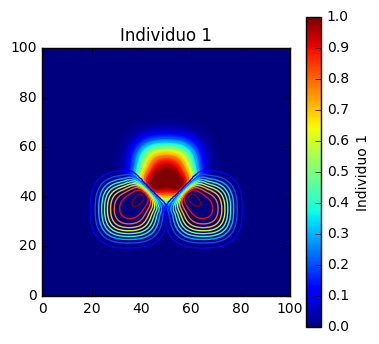

In [17]:
for step in range(steps):
    equ1.solve(var=u1, dt=timeStepDuration)
    equ2.solve(var=u2, dt=timeStepDuration)
    equ3.solve(var=u3, dt=timeStepDuration)
    eqp1.solve(var=p1, dt=timeStepDuration)
    eqp2.solve(var=p2, dt=timeStepDuration)
    eqp3.solve(var=p3, dt=timeStepDuration)
    
# Plotting results
if __name__ == '__main__':
    viewer = ThreeViewer(u1, u2, u3, datamin=0., datamax=1.0)
    viewer.plot()